In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
import os, re, glob

# Load Data and Prepare Dataset

In [8]:
DATA_PATH = 'G:\\DeepRFT'
TRAIN_SCENES = ['GoPro03961100',
                'GoPro03851101',
                'GoPro03841100',
                'GoPro03841105',
                'GoPro08541100',
                'GoPro08621100',
                'GoPro08811101'
                ]

TEST_SCENES = ['GoPro04101100']

KERNEL_INT_THRES = 0.75  # kernel complexity threshold
ID_THRES = 0.01  # less than 0.1 is considered as inlier

# traverse all train scenes and get the paths of inlier and outlier
train_paths = []
for scene in TRAIN_SCENES:
    train_paths.extend(glob.glob(os.path.join(DATA_PATH, scene, '**')))
train_id_paths, train_ood_paths = [], []
for p in train_paths:
    p_name = os.path.basename(p)  # get the name of the path
    try:
        i = float(re.findall(r'i=(\d+\.\d*)', p_name)[0])  # get the kernel complexity
        n = float(re.findall(r'n=(\d+\.\d*)', p_name)[0])  # get the noise ratio
    except:
        continue
    if i <= KERNEL_INT_THRES and n < ID_THRES:
        train_id_paths.append(p)
        print('Training ID path:', p)
    elif i <= KERNEL_INT_THRES and n >= ID_THRES:
        train_ood_paths.append(p)
        print('Training OOD path:', p)

# traverse all test scenes and get the paths of inlier and outlier
test_paths = []
for scene in TEST_SCENES:
    test_paths.extend(glob.glob(os.path.join(DATA_PATH, scene, '**')))
test_id_paths, test_ood_paths = [], []
for p in test_paths:
    p_name = os.path.basename(p)  # get the name of the path
    try:
        i = float(re.findall(r'i=(\d+\.\d*)', p_name)[0])  # get the kernel complexity
        n = float(re.findall(r'n=(\d+\.\d*)', p_name)[0])  # get the noise ratio
    except:
        continue
    if i <= KERNEL_INT_THRES and n < ID_THRES:
        test_id_paths.append(p)
        print('Training ID path:', p)
    elif i <= KERNEL_INT_THRES and n >= ID_THRES:
        test_ood_paths.append(p)
        print('Training OOD path:', p)
        
# summary data paths
print('Total ID train paths:', len(train_id_paths))
print('Total OOD train paths:', len(train_ood_paths))
print('Total ID test paths:', len(test_id_paths))
print('Total OOD test paths:', len(test_ood_paths))

Training ID path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.00_n=0.00
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.00_n=0.01
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.00_n=0.05
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.00_n=0.10
Training ID path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.25_n=0.00
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.25_n=0.01
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.25_n=0.05
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=19_i=0.25_n=0.10
Training ID path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=38_i=0.50_n=0.00
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=38_i=0.50_n=0.01
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=38_i=0.50_n=0.05
Training OOD path: G:\DeepRFT\GoPro03961100\GoPro0396_11_00_00_s=38_i=0.50_n=0.10
Training ID path: G

In [11]:
# load data and remove outliers

def remove_outliers(df):
    for col in df.columns:
        if col != 'class':
            z = abs((df[col] - np.mean(df[col]))/np.std(df[col]))
            df = df.iloc[np.where(z<2.5)[0],:]
    return df

REG_WIN_LEN = 5  # regression window length
train_id_csv_list, train_ood_csv_list = [], []
for id_path in train_id_paths:
    p_name = os.path.basename(id_path)
    n = float(re.findall(r'n=(\d+\.\d*)', p_name)[0])  # get the noise ratio
    
    try:
        id_csv = pd.read_csv(os.path.join(id_path, 'RMSE_fit%d_alt.csv'%REG_WIN_LEN))
        id_csv = remove_outliers(id_csv)
    except:
        continue
    
    # add class and noise level labels
    id_csv['class'] = 0
    id_csv['noise'] = n
    
    print(id_csv.describe())
    train_id_csv_list.append(id_csv)
    print(id_path, np.mean(id_csv, axis=0))
train_id_df = pd.concat(train_id_csv_list, axis=0)
    
for ood_path in train_ood_paths:
    p_name = os.path.basename(ood_path)
    n = float(re.findall(r'n=(\d+\.\d*)', p_name)[0])  # get the noise ratio
    
    try:
        ood_csv = pd.read_csv(os.path.join(ood_path, 'RMSE_fit%d_alt.csv'%REG_WIN_LEN))
        ood_csv = remove_outliers(ood_csv)
    except:
        continue
    
    # add class and noise level labels
    ood_csv['class'] = 1
    ood_csv['noise'] = n
    
    print(ood_csv.describe())
    train_ood_csv_list.append(ood_csv)
    print(ood_path, np.mean(ood_csv, axis=0))
train_ood_df = pd.concat(train_ood_csv_list, axis=0)

train_df = pd.concat([train_id_df, train_ood_df], axis=0)
print(train_df.shape)

       rmse_fit_list  xrmse_fit_list  rmse_list  xrmse_list  bias_list  \
count      93.000000       93.000000  93.000000   93.000000  93.000000   
mean        0.045504        0.007268   0.083027    0.022509   0.030883   
std         0.000548        0.000645   0.000580    0.000118   0.000374   
min         0.044129        0.005895   0.081708    0.022256   0.030051   
25%         0.045129        0.006756   0.082536    0.022421   0.030615   
50%         0.045602        0.007250   0.083031    0.022511   0.030931   
75%         0.045919        0.007701   0.083406    0.022575   0.031138   
max         0.046771        0.008716   0.084463    0.022757   0.031762   

       xbias_list  class  noise  
count   93.000000   93.0   93.0  
mean     0.014932    0.0    0.0  
std      0.000711    0.0    0.0  
min      0.013291    0.0    0.0  
25%      0.014467    0.0    0.0  
50%      0.014999    0.0    0.0  
75%      0.015434    0.0    0.0  
max      0.016408    0.0    0.0  
G:\DeepRFT\GoPro03961100\Go

In [17]:
test_id_csv_list, test_ood_csv_list = [], []
for id_path in test_id_paths:
    p_name = os.path.basename(id_path)
    n = float(re.findall(r'n=(\d+\.\d*)', p_name)[0])  # get the noise ratio
    
    try:
        id_csv = pd.read_csv(os.path.join(id_path, 'RMSE_fit%d_alt.csv'%REG_WIN_LEN))
        id_csv = remove_outliers(id_csv)
    except:
        continue
    
    # add class and noise level labels
    id_csv['class'] = 0
    id_csv['noise'] = n
    
    print(id_csv.describe())
    test_id_csv_list.append(id_csv)
    print(id_path, np.mean(id_csv, axis=0))
test_id_df = pd.concat(test_id_csv_list, axis=0)
    
for ood_path in test_ood_paths:
    p_name = os.path.basename(ood_path)
    n = float(re.findall(r'n=(\d+\.\d*)', p_name)[0])  # get the noise ratio
    
    try:
        ood_csv = pd.read_csv(os.path.join(ood_path, 'RMSE_fit%d_alt.csv'%REG_WIN_LEN))
        ood_csv = remove_outliers(ood_csv)
    except:
        continue
    
    # add class and noise level labels
    ood_csv['class'] = 1
    ood_csv['noise'] = n
    
    print(ood_csv.describe())
    test_ood_csv_list.append(ood_csv)
    print(ood_path, np.mean(ood_csv, axis=0))
test_ood_df = pd.concat(test_ood_csv_list, axis=0)

test_df = pd.concat([test_id_df, test_ood_df], axis=0)
print(test_df.shape)

       rmse_fit_list  xrmse_fit_list  rmse_list  xrmse_list  bias_list  \
count      24.000000       24.000000  24.000000   24.000000  24.000000   
mean        0.037050        0.004911   0.062157    0.020864   0.022864   
std         0.001810        0.000293   0.002563    0.001010   0.001244   
min         0.034658        0.004453   0.057311    0.019168   0.020587   
25%         0.035793        0.004669   0.060069    0.019820   0.021832   
50%         0.036631        0.004835   0.062291    0.020991   0.022953   
75%         0.037821        0.005185   0.063962    0.021481   0.023810   
max         0.041395        0.005472   0.066919    0.022805   0.025050   

       xbias_list  class  noise  
count   24.000000   24.0   24.0  
mean     0.015833    0.0    0.0  
std      0.000901    0.0    0.0  
min      0.014300    0.0    0.0  
25%      0.015102    0.0    0.0  
50%      0.016112    0.0    0.0  
75%      0.016376    0.0    0.0  
max      0.017541    0.0    0.0  
G:\DeepRFT\GoPro04101100\Go

# Training, Tuning & Testing (XGBoost)

In [13]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score

# define the grid search parameters for XGBoost
param_grid_xg = {
    'n_estimators': [10, 30, 60, 90],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7, 9, 10],
    'gamma': [0, 0.5],
    'subsample': [0.3,0.6, 0.9],
    'colsample_bytree': [0.6, 0.9],
    'reg_alpha': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [1, 1.25, 1.5, 1.75, 2.0]
}

# function to create result matrix for each model
def paramtuning_result(model,X_test,Y_test):
    #test accuracy
    test_accuracy = cross_val_score(model,X_test,Y_test,cv=5).mean()
    #test precision
    y_pred = model.predict(X_test)
    test_precision = precision_score(Y_test, y_pred)
    #test recall
    test_recall = recall_score(Y_test, y_pred)
    #test f1 score
    test_f1 = f1_score(Y_test, y_pred)
    #test auc
    y_pred_proba = model.predict_proba(X_test)[:,1]
    test_auc = roc_auc_score(Y_test, y_pred_proba)
    #area under precision recall curve
    test_ap = average_precision_score(Y_test, y_pred_proba)

    df = pd.DataFrame({'Model': [str(model)],
                        'Test Accuracy': [test_accuracy],
                        'Test Precision': [test_precision],
                        'Test Recall': [test_recall],
                        'Test F1 Score': [test_f1],
                        'Test AUC': [test_auc],
                        'Test Average Precision': [test_ap]
                        })
    return df

RANDOM_SEED = 123

In [16]:
x = train_df.loc[:, ['rmse_fit_list', 'xrmse_fit_list', 'xrmse_list', 'bias_list', 'xbias_list']]
y = train_df.loc[:, 'class']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

# find the optimal parameters for XGBoost
xg_model = XGBClassifier(
            learning_rate =0.1,
            n_estimators=60,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.9,
            colsample_bytree=0.9,
            objective= 'binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            reg_lambda = 1.0,
            reg_alpha = 0.25)

xg_model.fit(x_train,y_train)
paramtuning_result(xg_model, x_train, y_train)

,Model,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC,Test Average Precision
0,"XGBClassifier(base_score=None, booster=None, c...",0.967979,0.994494,0.991973,0.993232,0.999554,0.999781


In [23]:
# test on the testing dataset
x_test = test_df.loc[:, ['rmse_fit_list', 'xrmse_fit_list', 'xrmse_list', 'bias_list', 'xbias_list']]
y_test = test_df.loc[:, 'class']

PROB_THRES = 0.9

test_probs = xg_model.predict_proba(x_test)[:,1]
y_pred_test = (test_probs >= PROB_THRES).astype(int)

Overall accuracy: 0.8728
Overall average precision: 0.9436
Overall ROC AUC: 0.9433
Noise level: 0.000 , accuracy:     0.8606, average precision:    -0.0000, ROC AUC:        nan
Noise level: 0.003 , accuracy:     0.9732, average precision:    -0.0000, ROC AUC:        nan
Noise level: 0.006 , accuracy:     1.0000, average precision:    -0.0000, ROC AUC:        nan
Noise level: 0.009 , accuracy:     0.5283, average precision:    -0.0000, ROC AUC:        nan
Noise level: 0.010 , accuracy:     0.9571, average precision:     1.0000, ROC AUC:        nan
Noise level: 0.020 , accuracy:     0.5833, average precision:     1.0000, ROC AUC:        nan
Noise level: 0.030 , accuracy:     0.9350, average precision:     1.0000, ROC AUC:        nan
Noise level: 0.040 , accuracy:     1.0000, average precision:     1.0000, ROC AUC:        nan
Noise level: 0.060 , accuracy:     1.0000, average precision:     1.0000, ROC AUC:        nan
Noise level: 0.080 , accuracy:     1.0000, average precision:     1.000

c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ozlab\.conda\

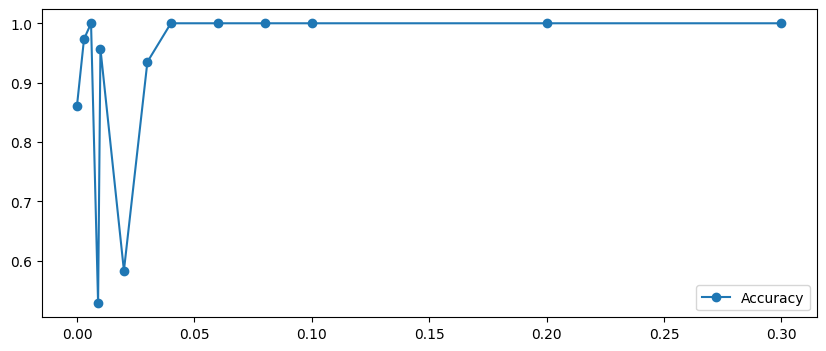

In [27]:
# analyze test results

# overall accuracy, ROCAUC, AP
acc_all = accuracy_score(y_test, y_pred_test)
ap_all = average_precision_score(y_test, test_probs)
fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_all = auc(fpr, tpr)
print('Overall accuracy: {:.4f}'.format(acc_all))
print('Overall average precision: {:.4f}'.format(ap_all))
print('Overall ROC AUC: {:.4f}'.format(roc_all))

# accuracy, ROCAUC, AP for each noise level
noise_levels = np.unique(test_df['noise'])
acc_list = np.zeros_like(noise_levels)
ap_list = np.zeros_like(noise_levels)
roc_list = np.zeros_like(noise_levels)
for idx, n in enumerate(noise_levels):
    acc_n = accuracy_score(y_test[test_df['noise']==n], y_pred_test[test_df['noise']==n])
    ap_n = average_precision_score(y_test[test_df['noise']==n], test_probs[test_df['noise']==n])
    fpr_n, tpr_n, thresholds_n = roc_curve(y_test[test_df['noise']==n], test_probs[test_df['noise']==n])
    roc_n = auc(fpr_n, tpr_n)
    acc_list[idx] = acc_n
    ap_list[idx] = ap_n
    roc_list[idx] = roc_n

# print results
for n, a, p, r in zip(noise_levels, acc_list, ap_list, roc_list):
    print('Noise level: {:<6.3f}, accuracy: {:>10.4f}, average precision: {:>10.4f}, ROC AUC: {:>10.4f}'.format(n, a, p, r))  

# visualize results
f_acc = plt.figure(figsize=(10,4))
ax = f_acc.add_subplot(1,1,1)
ax.plot(noise_levels, acc_list, 'o-', label="Accuracy")
ax.legend()

# Training, Tuning & Testing (Baseline 1)

In [28]:
x = train_df.loc[:, 'xrmse_list']
y = train_df.loc[:, 'class']

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

# find the optimal parameters for XGBoost
xg_base = XGBClassifier(
            learning_rate =0.1,
            n_estimators=60,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.9,
            colsample_bytree=0.9,
            objective= 'binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            reg_lambda = 1.0,
            reg_alpha = 0.25)

xg_base.fit(x_train,y_train)
paramtuning_result(xg_base, x_train, y_train)

,Model,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test AUC,Test Average Precision
0,"XGBClassifier(base_score=None, booster=None, c...",0.82573,0.866875,0.935361,0.899817,0.941484,0.971434


In [29]:
# test on the testing dataset
x_test = test_df.loc[:, 'xrmse_list']
y_test = test_df.loc[:, 'class']

PROB_THRES = 0.9

test_probs_base = xg_base.predict_proba(x_test)[:,1]
y_pred_test_base = (test_probs_base >= PROB_THRES).astype(int)

Overall accuracy of baseline: 0.7601
Overall average precision of baseline: 0.8231
Overall ROC AUC of baseline: 0.7543
Baseline model: noise level: 0.000 , accuracy:     0.9856, average precision:    -0.0000, ROC AUC:        nan
Baseline model: noise level: 0.003 , accuracy:     1.0000, average precision:    -0.0000, ROC AUC:        nan
Baseline model: noise level: 0.006 , accuracy:     1.0000, average precision:    -0.0000, ROC AUC:        nan
Baseline model: noise level: 0.009 , accuracy:     1.0000, average precision:    -0.0000, ROC AUC:        nan
Baseline model: noise level: 0.010 , accuracy:     0.0000, average precision:     1.0000, ROC AUC:        nan
Baseline model: noise level: 0.020 , accuracy:     0.0000, average precision:     1.0000, ROC AUC:        nan
Baseline model: noise level: 0.030 , accuracy:     0.2927, average precision:     1.0000, ROC AUC:        nan
Baseline model: noise level: 0.040 , accuracy:     1.0000, average precision:     1.0000, ROC AUC:        nan
B

c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\ozlab\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\ozlab\.conda\

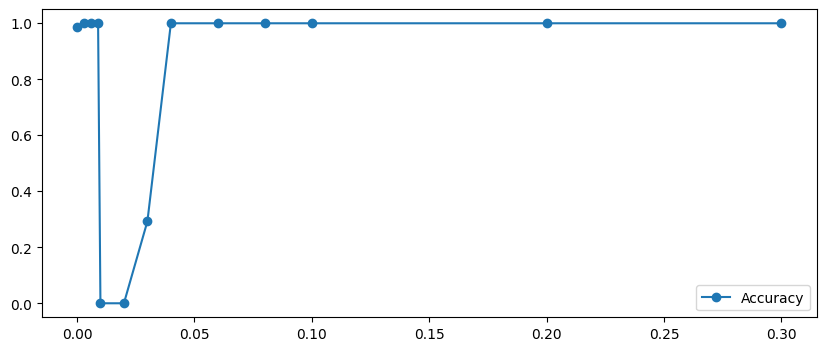

In [30]:
# analyze test results

# overall accuracy, ROCAUC, AP
acc_all_base = accuracy_score(y_test, y_pred_test_base)
ap_all_base = average_precision_score(y_test, test_probs_base)
fpr, tpr, thresholds = roc_curve(y_test, test_probs_base)
roc_all_base = auc(fpr, tpr)
print('Overall accuracy of baseline: {:.4f}'.format(acc_all_base))
print('Overall average precision of baseline: {:.4f}'.format(ap_all_base))
print('Overall ROC AUC of baseline: {:.4f}'.format(roc_all_base))

# accuracy, ROCAUC, AP for each noise level
acc_list_base = np.zeros_like(noise_levels)
ap_list_base = np.zeros_like(noise_levels)
roc_list_base = np.zeros_like(noise_levels)
for idx, n in enumerate(noise_levels):
    acc_n = accuracy_score(y_test[test_df['noise']==n], y_pred_test_base[test_df['noise']==n])
    ap_n = average_precision_score(y_test[test_df['noise']==n], test_probs_base[test_df['noise']==n])
    fpr_n, tpr_n, thresholds_n = roc_curve(y_test[test_df['noise']==n], test_probs_base[test_df['noise']==n])
    roc_n = auc(fpr_n, tpr_n)
    acc_list_base[idx] = acc_n
    ap_list_base[idx] = ap_n
    roc_list_base[idx] = roc_n

# print results
for n, a, p, r in zip(noise_levels, acc_list_base, ap_list_base, roc_list_base):
    print('Baseline model: noise level: {:<6.3f}, accuracy: {:>10.4f}, average precision: {:>10.4f}, ROC AUC: {:>10.4f}'.format(n, a, p, r))  

# visualize results
f_acc_base = plt.figure(figsize=(10,4))
ax = f_acc_base.add_subplot(1,1,1)
ax.plot(noise_levels, acc_list_base, 'o-', label="Accuracy")
ax.legend()